In [1]:
import h5py

In [202]:
f = h5py.File('../event_dump.h5','r')
event_data = f['event_data'][:]

In [3]:
from __future__ import print_function
import numpy as np

In [205]:
f.keys()

<KeysViewHDF5 ['directions', 'energies', 'event_data', 'event_ids', 'labels', 'mGridDirX', 'mGridDirY', 'mGridDirZ', 'mGridPmt', 'mGridX', 'mGridY', 'mGridZ', 'pids', 'positions']>

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

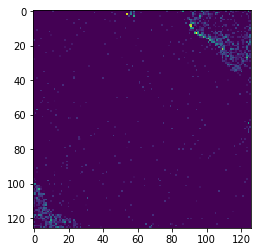

In [5]:
plt.imshow(event_data[0,:,:,0])

In [91]:
import torch 

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [7]:
Cin = 1; # Q
Hin = event_data.shape[1];
Win = event_data.shape[2];

pad = 2;

Cout = 4;
Hflt = 2*pad+1;
Wflt = 2*pad+1;

filters = torch.randn(Cout,Cin,Hflt,Wflt);
inputs = torch.tensor(event_data[0:5,:,:,0]).unsqueeze(1);
outputs = torch.nn.functional.conv2d(geometricPad(inputs, pad), filters);

print('filters.shape = ', filters.shape, 'should be (',Cout,',',Cin,',',Hflt,',',Wflt,')');
print('inputs .shape = ', inputs.shape, 'should be (5,',Cin,',',Hin,',',Win,')');
print('outputs.shape = ', outputs.shape, 'should be (5,',Cout,',',Hin,',',Win,')');

filters.shape =  torch.Size([4, 1, 5, 5]) should be ( 4 , 1 , 5 , 5 )
inputs .shape =  torch.Size([5, 1, 126, 126]) should be (5, 1 , 126 , 126 )
outputs.shape =  torch.Size([5, 4, 126, 126]) should be (5, 4 , 126 , 126 )


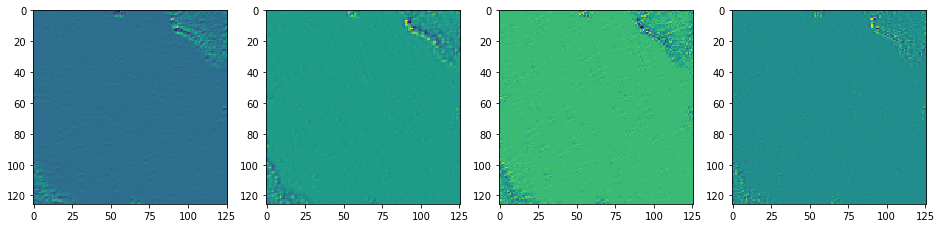

In [8]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(outputs[0,0,:,:])
ax1.imshow(outputs[0,1,:,:])
ax2.imshow(outputs[0,2,:,:])
ax3.imshow(outputs[0,3,:,:])
plt.show()

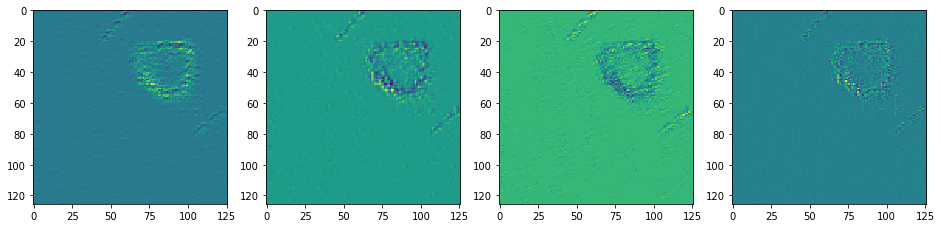

In [9]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(outputs[1,0,:,:])
ax1.imshow(outputs[1,1,:,:])
ax2.imshow(outputs[1,2,:,:])
ax3.imshow(outputs[1,3,:,:])
plt.show()

In [10]:
f.keys()

<KeysViewHDF5 ['directions', 'energies', 'event_data', 'event_ids', 'labels', 'mGridDirX', 'mGridDirY', 'mGridDirZ', 'mGridPmt', 'mGridX', 'mGridY', 'mGridZ', 'pids', 'positions']>

In [11]:
f['mGridX'][()].shape

(126, 126)

In [12]:
mGridX = torch.tensor(f['mGridX'][()])
M = mGridX.shape[0]
mGridI = torch.tensor(np.reshape(np.repeat(np.arange(M),M), (M,M)))
mGridJ = mGridI.t()
print('mGridI:', mGridI[0,0], mGridI[0,1], mGridI[1,0], mGridI[1,1])
print('mGridJ:', mGridJ[0,0], mGridJ[0,1], mGridJ[1,0], mGridJ[1,1])

mGridI: tensor(0) tensor(0) tensor(1) tensor(1)
mGridJ: tensor(0) tensor(1) tensor(0) tensor(1)


In [13]:
geometricPad(mGridI.unsqueeze(0).unsqueeze(0)).shape

torch.Size([1, 1, 128, 128])

In [14]:
geometricPad(mGridI.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).shape

torch.Size([128, 128])

In [15]:
pad

2

In [16]:
dij = np.reshape(np.repeat(np.arange(-pad,pad+1),2*pad+1), (2*pad+1,2*pad+1));
dis = dij.flatten()
djs = dij.transpose().flatten();
print(dis)
print(djs)

[-2 -2 -2 -2 -2 -1 -1 -1 -1 -1  0  0  0  0  0  1  1  1  1  1  2  2  2  2
  2]
[-2 -1  0  1  2 -2 -1  0  1  2 -2 -1  0  1  2 -2 -1  0  1  2 -2 -1  0  1
  2]


In [17]:
np.arange(dis.size)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [18]:
mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
  f['mGridX'][()],
  f['mGridY'][()],
  f['mGridZ'][()],
  f['mGridDirX'][()],
  f['mGridDirY'][()],
  f['mGridDirZ'][()]
])

print(mGridPmt.shape, mGridCoord.shape)

(126, 126) (6, 126, 126)


In [19]:
# M: number of cols or rows grid

mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
  f['mGridX'][()],
  f['mGridY'][()],
  f['mGridZ'][()],
  f['mGridDirX'][()],
  f['mGridDirY'][()],
  f['mGridDirZ'][()]
])
Ncoords = mGridCoord.shape[0]

M = mGridPmt.shape[0]
mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
mGridJ = mGridI.transpose()


dij = np.reshape(np.repeat(np.arange(-pad,pad+1),2*pad+1), (2*pad+1,2*pad+1));
dis = dij.flatten()
djs = dij.transpose().flatten();

i1 = 20
j1 = 30

pmtI1 = mGridPmt[i1,j1]; # index in tank.pmt
mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).numpy();
mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).numpy();

x      = []; # coordinates for each direction
skip   = []; # for each direction whether we should skip or not
processedPmtI2s = [];
Nsites = dis.size;

for diji in range(Nsites):
    di = dis[diji]
    dj = djs[diji]
    i2 = mGridIpad[pad+i1+di,pad+j1+dj];
    j2 = mGridJpad[pad+i1+di,pad+j1+dj];
    #print(i2,j2)
    pmtI2 = mGridPmt[i2,j2];
    #print(pmtI1, pmtI2)

    if (pmtI1 == 0 or pmtI2 == 0 or pmtI2 in processedPmtI2s):
        x.append(np.zeros(Ncoords))
        skip.append(True)
        processedPmtI2s.append(pmtI2)
        continue

    dx21 = mGridCoord[:,i2,j2] - mGridCoord[:,i1,j1];
    x.append(dx21)
    skip.append(False)
    processedPmtI2s.append(pmtI2)

x = np.stack(x)
print('x.shape:', x.shape)

X = [];
for k in range(Nsites):
    if skip[k]:
        X.append(np.zeros(1+Ncoords));
        # if we also do second derivatives, this needs to be extended by a N*(N+1)/2 term
        next;
    
    X.append(np.hstack([np.array(1.), x[k,:]]))
    # if we also do second derivatives, this needs to be extended by a x*x term

X = np.stack(X)
print('X.shape:', X.shape)
# X is 1 and first derivatives


# regularization strength
Lambda = 1.; # this should be somewhat smaller than typical values of x

MA = np.zeros((Nsites,Nsites));
for k in range(Nsites):
    if skip[k]:
        MA[k,k] = 1.
        continue
    
    for j in range(Nsites):
        if skip[j]:
            continue
        
        MA[k,j] = 1. + np.sum(x[k,:]*x[j,:]) + Lambda**2 * (k==j);

print('MA.shape:', MA.shape)
AA = np.linalg.solve(MA, X)
print('AA.shape:', AA.shape)

# AA has dimension [dij,coord]
# so let's reshape to [di,dj,coord]
AAA = np.zeros(AA.size).reshape((2*pad+1,2*pad+1,1+Ncoords))
for k in range(Nsites):
    AAA[dis[k]+pad,djs[k]+pad,:] = AA[k,:]

print('AAA.shape:', AAA.shape)

print('AAA[:,:,0]\n', AAA[:,:,0])

x.shape: (25, 6)
X.shape: (25, 7)
MA.shape: (25, 25)
AA.shape: (25, 7)
AAA.shape: (5, 5, 7)
AAA[:,:,0]
 [[ 0.02258243 -0.01281797 -0.02767646  0.01358661  0.10510857]
 [ 0.0806266   0.18499376 -0.06009007 -0.01801172  0.05865176]
 [ 0.01081738  0.05420394  0.14959336  0.05385858 -0.03839679]
 [ 0.03166681  0.01680832  0.00608799  0.10313654 -0.09178974]
 [ 0.05893332 -0.01560529  0.02647307  0.05807139  0.04419384]]


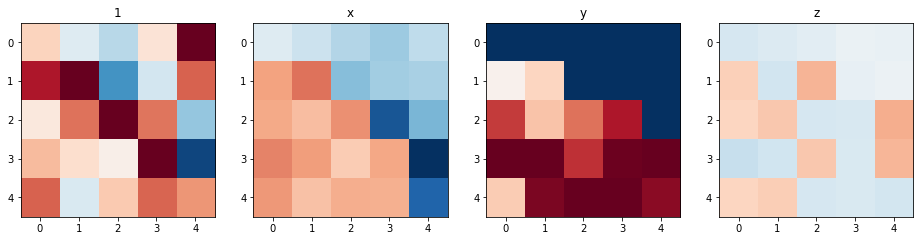

In [20]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
ax0.imshow(-AAA[:,:,0], cmap='RdBu', vmin=-0.1, vmax=+0.1);     ax0.set_title('1')
ax1.imshow(-AAA[:,:,1], cmap='RdBu', vmin=-0.001, vmax=+0.001); ax1.set_title('x')
ax2.imshow(-AAA[:,:,2], cmap='RdBu', vmin=-0.001, vmax=+0.001); ax2.set_title('y')
ax3.imshow(-AAA[:,:,3], cmap='RdBu', vmin=-0.1, vmax=+0.1);     ax3.set_title('z')
plt.show()

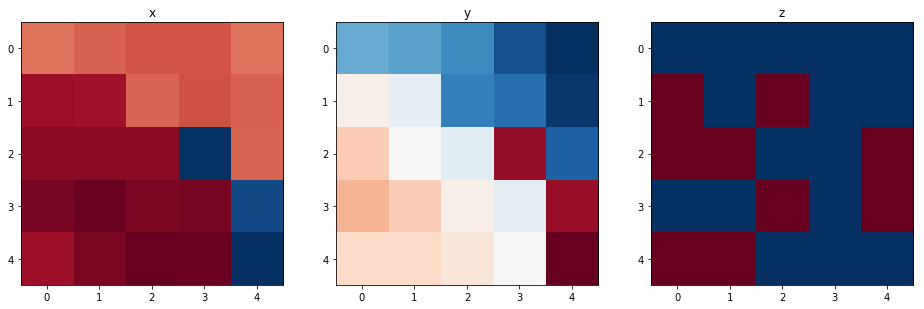

In [21]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16,8),facecolor='w')
ax0.imshow(-x[:,0].reshape((2*pad+1,2*pad+1)), cmap='RdBu'); ax0.set_title('x')
ax1.imshow(-x[:,1].reshape((2*pad+1,2*pad+1)), cmap='RdBu'); ax1.set_title('y')
ax2.imshow(-x[:,2].reshape((2*pad+1,2*pad+1)), cmap='RdBu'); ax2.set_title('z')
plt.show()

In [69]:
# M: number of cols or rows grid

mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
  f['mGridX'][()],
  f['mGridY'][()],
  f['mGridZ'][()],
  f['mGridDirX'][()],
  f['mGridDirY'][()],
  f['mGridDirZ'][()]
])
Ncoords = mGridCoord.shape[0]

M = mGridPmt.shape[0]
mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
mGridJ = mGridI.transpose()

Nshift = 2*pad+1
dij = np.reshape(np.repeat(np.arange(-pad,pad+1),Nshift), (Nshift,Nshift));
dis = dij.flatten()
djs = dij.transpose().flatten();
Nsites = dis.size;

mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();


mGridAA = np.zeros((M,M,Nsites,1+Ncoords)) # 1+Ncoords needs to be extended if we include 2nd order deriv
for i1 in range(M):
    print('%d/%d' % (i1,M))
    for j1 in range(M):
        pmtI1 = mGridPmt[i1,j1]; # index in tank.pmt

        x      = []; # coordinates for each direction
        skip   = []; # for each direction whether we should skip or not
        processedPmtI2s = [];

        for diji in range(Nsites):
            di = dis[diji]
            dj = djs[diji]
            i2 = mGridIpad[pad+i1+di,pad+j1+dj];
            j2 = mGridJpad[pad+i1+di,pad+j1+dj];
            #print(i2,j2)
            pmtI2 = mGridPmt[i2,j2];
            #print(pmtI1, pmtI2)

            if (pmtI1 == -1 or pmtI2 == -1 or pmtI2 in processedPmtI2s):
                x.append(np.zeros(Ncoords))
                skip.append(True)
                processedPmtI2s.append(pmtI2)
                continue

            dx21 = mGridCoord[:,i2,j2] - mGridCoord[:,i1,j1];
            x.append(dx21)
            skip.append(False)
            processedPmtI2s.append(pmtI2)

        x = np.stack(x)

        X = [];
        for k in range(Nsites):
            if skip[k]:
                X.append(np.zeros(1+Ncoords));
                # if we also do second derivatives, this needs to be extended by a N*(N+1)/2 term
                continue;

            X.append(np.hstack([np.array(1.), x[k,:]]))
            # if we also do second derivatives, this needs to be extended by a x*x term

        X = np.stack(X)
        # X is 1 and first derivatives


        # regularization strength
        Lambda = 1.; # this should be somewhat smaller than typical values of x

        MA = np.zeros((Nsites,Nsites));
        for k in range(Nsites):
            if skip[k]:
                MA[k,k] = 1.
                continue

            for j in range(Nsites):
                if skip[j]:
                    continue

                MA[k,j] = 1. + np.sum(x[k,:]*x[j,:]) + Lambda**2 * (k==j);

        AA = np.linalg.solve(MA, X)
        mGridAA[i1,j1,:,:] = AA

0/126
1/126
2/126
3/126
4/126
5/126
6/126
7/126
8/126
9/126
10/126
11/126
12/126
13/126
14/126
15/126
16/126
17/126
18/126
19/126
20/126
21/126
22/126
23/126
24/126
25/126
26/126
27/126
28/126
29/126
30/126
31/126
32/126
33/126
34/126
35/126
36/126
37/126
38/126
39/126
40/126
41/126
42/126
43/126
44/126
45/126
46/126
47/126
48/126
49/126
50/126
51/126
52/126
53/126
54/126
55/126
56/126
57/126
58/126
59/126
60/126
61/126
62/126
63/126
64/126
65/126
66/126
67/126
68/126
69/126
70/126
71/126
72/126
73/126
74/126
75/126
76/126
77/126
78/126
79/126
80/126
81/126
82/126
83/126
84/126
85/126
86/126
87/126
88/126
89/126
90/126
91/126
92/126
93/126
94/126
95/126
96/126
97/126
98/126
99/126
100/126
101/126
102/126
103/126
104/126
105/126
106/126
107/126
108/126
109/126
110/126
111/126
112/126
113/126
114/126
115/126
116/126
117/126
118/126
119/126
120/126
121/126
122/126
123/126
124/126
125/126


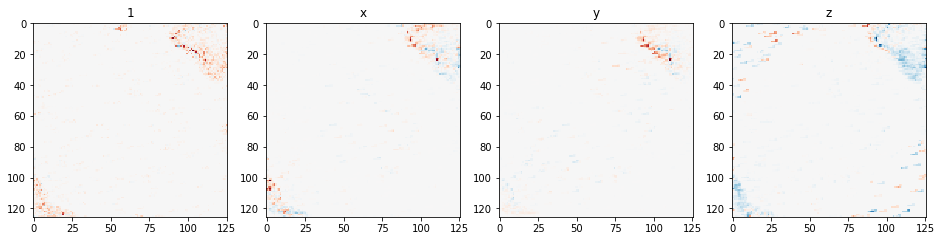

In [98]:
Cin = 1; # Q
Hin = event_data.shape[1];
Win = event_data.shape[2];

# Cout = 4;
# Hflt = 2*pad+1;
# Wflt = 2*pad+1;

# filters = torch.randn(Cout,Cin,Hflt,Wflt);
inputs = torch.tensor(event_data[0:5,:,:,0]).unsqueeze(1);
# outputs = torch.nn.functional.conv2d(geometricPad(inputs, pad), filters);

# print('filters.shape = ', filters.shape, 'should be (',Cout,',',Cin,',',Hflt,',',Wflt,')');
# print('inputs .shape = ', inputs.shape, 'should be (5,',Cin,',',Hin,',',Win,')');
# print('outputs.shape = ', outputs.shape, 'should be (5,',Cout,',',Hin,',',Win,')');

inputsPad = geometricPad(inputs, pad); # (B,C,W,H)

Nbatch = inputs.shape[0]
Ntaylor = 1 + Ncoords

tGridAA = torch.tensor(mGridAA, dtype=torch.float)

tayloredInput = torch.zeros((Nbatch,Ntaylor,Cin,Hin,Win))
for k in range(Ntaylor):
    # shift grid according to position (without copying the data)
    inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
    inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
    # fill
    out = torch.add(tayloredInput, torch.einsum('ijd,bcij->bdcij', tGridAA[:,:,k,:], inputsPadD2))
    tayloredInput = out

tayloredInput = tayloredInput.view(Nbatch, Ntaylor*Cin, Hin, Win)


def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)


fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[0,0,:,:]); ax0.set_title('1')
imshowRdBu(ax1, tayloredInput[0,1,:,:]); ax1.set_title('x')
imshowRdBu(ax2, tayloredInput[0,2,:,:]); ax2.set_title('y')
imshowRdBu(ax3, tayloredInput[0,3,:,:]); ax3.set_title('z')
plt.show()

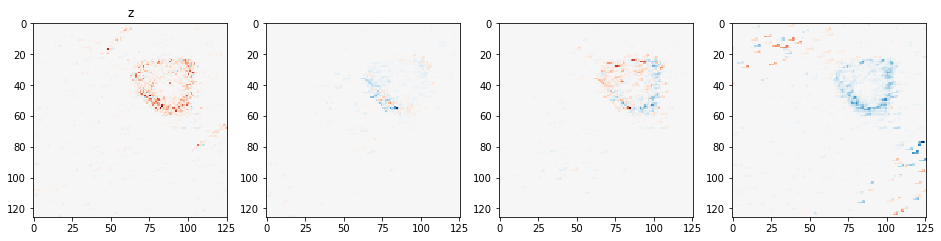

In [93]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[1,0,:,:]); ax0.set_title('1')
imshowRdBu(ax1, tayloredInput[1,1,:,:]); ax1.set_title('x')
imshowRdBu(ax2, tayloredInput[1,2,:,:]); ax2.set_title('y')
imshowRdBu(ax3, tayloredInput[1,3,:,:]); ax3.set_title('z')
plt.show()

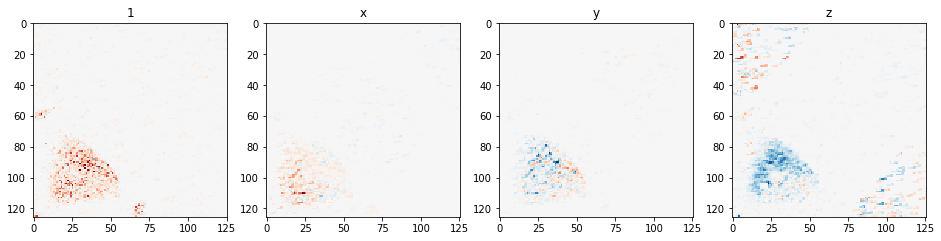

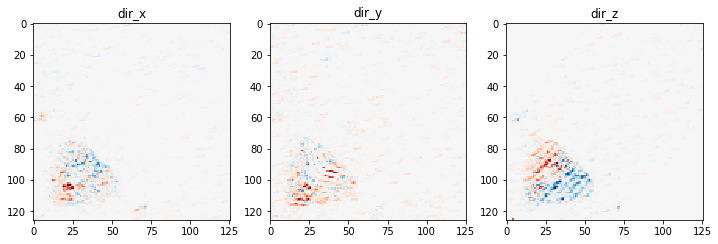

In [167]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[4,0,:,:]); ax0.set_title('1')
imshowRdBu(ax1, tayloredInput[4,1,:,:]); ax1.set_title('x')
imshowRdBu(ax2, tayloredInput[4,2,:,:]); ax2.set_title('y')
imshowRdBu(ax3, tayloredInput[4,3,:,:]); ax3.set_title('z')
plt.show()

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[4,4,:,:]); ax0.set_title('dir_x')
imshowRdBu(ax1, tayloredInput[4,5,:,:]); ax1.set_title('dir_y')
imshowRdBu(ax2, tayloredInput[4,6,:,:]); ax2.set_title('dir_z')
plt.show()

Especially looking at the direction I think it's working? (dir_z e.g. seems to be picking up the direction of the photons in z-direction, whereas dir_x has the x-direction?)

can we make the whole thing faster by using vectorized operations for everything?

In [22]:
# M: number of cols or rows grid

mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
  f['mGridX'][()],
  f['mGridY'][()],
  f['mGridZ'][()],
  f['mGridDirX'][()],
  f['mGridDirY'][()],
  f['mGridDirZ'][()]
])
Ncoords = mGridCoord.shape[0]

M = mGridPmt.shape[0]
mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
mGridJ = mGridI.transpose()

Nshift = 2*pad+1
dij = np.reshape(np.repeat(np.arange(-pad,pad+1),Nshift), (Nshift,Nshift));
dis = dij.flatten()
djs = dij.transpose().flatten();
Nsites = dis.size;

mGridPmtpad = geometricPad(torch.tensor(mGridPmt).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();

mGridCoordPad = geometricPad(torch.tensor(mGridCoord).unsqueeze(0), pad).squeeze(0).numpy();


mGridAA2 = np.zeros((M,M,Nshift,Nshift,1+Ncoords)) # 1+Ncoords needs to be extended if we include 2nd order deriv

pmtI1 = mGridPmt[:,:]; # index in tank.pmt

x      = np.zeros((Ncoords,M,M,Nsites));     # coordinates for each direction
skip   = np.zeros((M,M,Nsites), dtype=bool); # for each direction whether we should skip or not
processedPmtI2s = np.zeros((M,M,Nsites), dtype=int) - 1;

for diji in range(Nsites):
    di = dis[diji]
    dj = djs[diji]
    i2 = mGridIpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    j2 = mGridJpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    pmtI2 = mGridPmtpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
    processedPmtI2s[:,:,diji] = pmtI2;
    
    skip[:,:,diji] = np.logical_or(np.equal(pmtI1,-1), np.equal(pmtI2,-1));
    for prev_diji in range(diji):
        skip[:,:,diji] = np.logical_or(skip[:,:,diji], np.equal(processedPmtI2s[:,:,prev_diji],pmtI2));
    
    x[:,:,:,diji] = mGridCoordPad[:,pad+di:pad+M+di,pad+dj:pad+M+dj] - mGridCoord; # 

# x: (Ncoords,M,M,Nsites)
print('x.shape:', x.shape)
# X: (Ntaylor,M,M,Nsites)    Ntaylor = 1 + Ncoords
X = np.concatenate([np.expand_dims(np.ones(x.shape[1:]),0),x])
print('X.shape:', X.shape)
X = np.where(np.expand_dims(skip, 0), 0., X);
# if we also do second derivatives, X needs to be extended by a x*x term

# regularization strength
Lambda = 1.; # this should be somewhat smaller than typical values of x

MA = np.zeros((M,M,Nsites,Nsites));
for k in range(Nsites):
    for j in range(Nsites):
        MA[:,:,k,j] = np.add(np.sum(x[:,:,:,k]*x[:,:,:,j], axis=0), 1. + Lambda**2 * (k==j));
    # clear skip entries
    MA[:,:,k,:] = np.where(np.expand_dims(skip[:,:,k],-1), 0., MA[:,:,k,:]);
    MA[:,:,:,j] = np.where(np.expand_dims(skip[:,:,j],-1), 0., MA[:,:,:,j]);
    # set diagonal:
    MA[:,:,k,k] = np.where(skip[:,:,k], 1., MA[:,:,k,k]);

#print('MA.shape:',MA.shape)
#print(MA[0,1,:,:])
#print(np.linalg.inv(MA[0,1,:,:]))
print("starting inversion... (may take a few seconds)")
AA = np.einsum('hwsi,thwi->thws', np.linalg.inv(MA), X)
print("done")
print('AA.shape:', AA.shape)

x.shape: (6, 126, 126, 25)
X.shape: (7, 126, 126, 25)
starting inversion... (may take a few seconds)
done
AA.shape: (7, 126, 126, 25)


that was *way* faster

tGridAA.shape: torch.Size([7, 126, 126, 25])
tayloredInput.shape: torch.Size([5, 7, 1, 126, 126])
inputsPad.shape: torch.Size([5, 1, 130, 130])


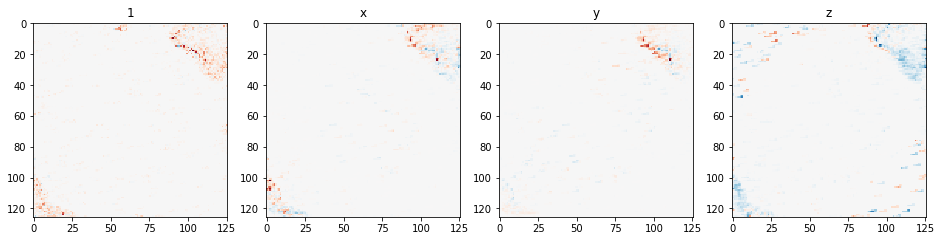

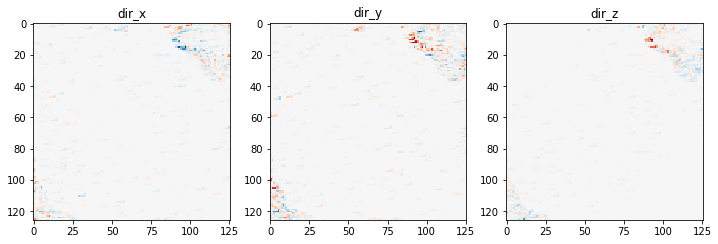

In [24]:
mGridAA = AA

Cin = 1; # Q
Hin = event_data.shape[1];
Win = event_data.shape[2];

# Cout = 4;
# Hflt = 2*pad+1;
# Wflt = 2*pad+1;

# filters = torch.randn(Cout,Cin,Hflt,Wflt);
inputs = torch.tensor(event_data[0:5,:,:,0]).unsqueeze(1);
# outputs = torch.nn.functional.conv2d(geometricPad(inputs, pad), filters);

# print('filters.shape = ', filters.shape, 'should be (',Cout,',',Cin,',',Hflt,',',Wflt,')');
# print('inputs .shape = ', inputs.shape, 'should be (5,',Cin,',',Hin,',',Win,')');
# print('outputs.shape = ', outputs.shape, 'should be (5,',Cout,',',Hin,',',Win,')');

inputsPad = geometricPad(inputs, pad); # (B,C,W,H)

Nbatch = inputs.shape[0]
Ntaylor = 1 + Ncoords

tGridAA = torch.tensor(mGridAA, dtype=torch.float)

tayloredInput = torch.zeros((Nbatch,Ntaylor,Cin,Hin,Win))
print('tGridAA.shape:', tGridAA.shape)
print('tayloredInput.shape:', tayloredInput.shape)
print('inputsPad.shape:', inputsPad.shape)
for k in range(Ntaylor):
    # shift grid according to position (without copying the data)
    inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
    inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
    # fill
    out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', tGridAA[:,:,:,k], inputsPadD2))
    tayloredInput = out

tayloredInput = tayloredInput.view(Nbatch, Ntaylor*Cin, Hin, Win)


def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)


ev=0
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,0,:,:]); ax0.set_title('1')
imshowRdBu(ax1, tayloredInput[ev,1,:,:]); ax1.set_title('x')
imshowRdBu(ax2, tayloredInput[ev,2,:,:]); ax2.set_title('y')
imshowRdBu(ax3, tayloredInput[ev,3,:,:]); ax3.set_title('z')
plt.show()

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12,8),facecolor='w')
imshowRdBu(ax0, tayloredInput[ev,4,:,:]); ax0.set_title('dir_x')
imshowRdBu(ax1, tayloredInput[ev,5,:,:]); ax1.set_title('dir_y')
imshowRdBu(ax2, tayloredInput[ev,6,:,:]); ax2.set_title('dir_z')
plt.show()

result seems to be consistent with what we had before

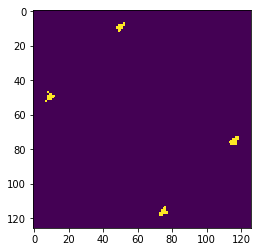

In [25]:
plt.imshow(pmtI1 == -1)

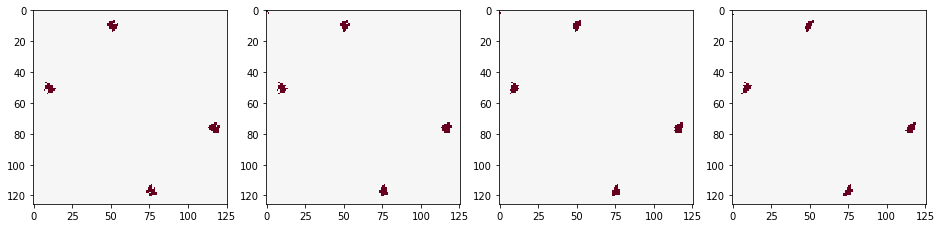

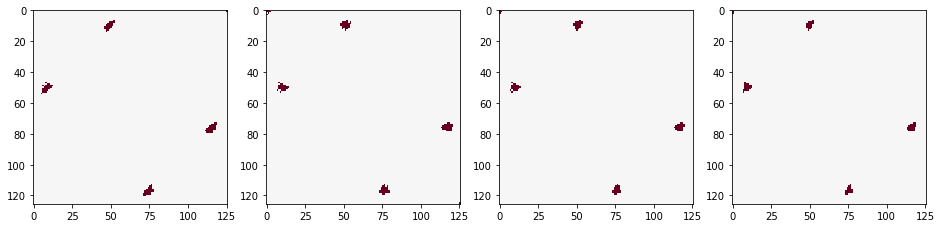

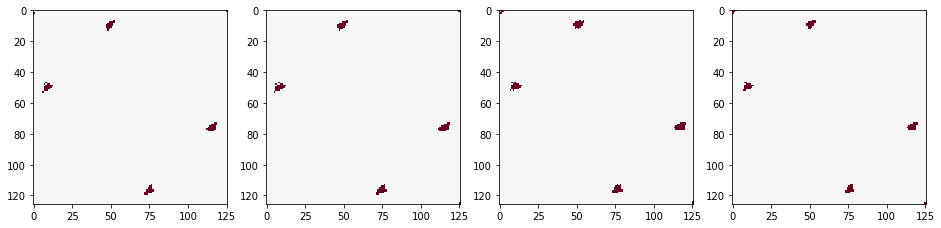

In [26]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, torch.tensor(skip[:,:,0].astype(int)))
imshowRdBu(ax1, torch.tensor(skip[:,:,1].astype(int)))
imshowRdBu(ax2, torch.tensor(skip[:,:,2].astype(int)))
imshowRdBu(ax3, torch.tensor(skip[:,:,3].astype(int)))
plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, torch.tensor(skip[:,:,4].astype(int)))
imshowRdBu(ax1, torch.tensor(skip[:,:,5].astype(int)))
imshowRdBu(ax2, torch.tensor(skip[:,:,6].astype(int)))
imshowRdBu(ax3, torch.tensor(skip[:,:,7].astype(int)))
plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(16,8),facecolor='w')
imshowRdBu(ax0, torch.tensor(skip[:,:,8].astype(int)))
imshowRdBu(ax1, torch.tensor(skip[:,:,9].astype(int)))
imshowRdBu(ax2, torch.tensor(skip[:,:,10].astype(int)))
imshowRdBu(ax3, torch.tensor(skip[:,:,11].astype(int)))
plt.show()

In [192]:
class TopoConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout):
        super(TopoConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.conv2d = torch.nn.Conv2d(Cin*Ntaylor,Cout,1)
        self.AA = tGridAA
        # 1x1 convolution since the neighbor information is encoded in the additional channels out Ntaylor
 
    def forward(self, x):
        Nbatch = x.shape[0]
        Hin = x.shape[2]
        Win = x.shape[3]
        
        inputsPad = geometricPad(x, pad); # (B,C,W,H)
        tayloredInput = x.new_zeros((Nbatch,Ntaylor,self.Cin,Hin,Win))
        for k in range(Ntaylor):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, pad+int(dis[k]), M)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, pad+int(djs[k]), M)
            # fill
            out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', self.AA[:,:,:,k], inputsPadD2))
            tayloredInput = out

        tayloredInput = tayloredInput.view(Nbatch, Ntaylor*self.Cin, Hin, Win)
        return self.conv2d(tayloredInput)
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TopoConv2d, self).cpu()
        self.AA.cpu()
        return self
    
    def cuda(self):
        super(TopoConv2d, self).cuda()
        self.AA = self.AA.cuda()
        return self


class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # B,C=2,H=126,W=126
            TopoConv2d( 2,16), torch.nn.ReLU(),
            TopoConv2d(16,32), torch.nn.ReLU(),
            # B,C=32,H=126,W=126
            torch.nn.MaxPool2d(2,2),
            # B,C=32,H=63,W=63
            torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.Conv2d(32,32,3,padding=1), torch.nn.ReLU())
            # B,C=32,H=63,W=63
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            #torch.nn.MaxPool2d(2,2),
            #torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            #torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(32,32), torch.nn.ReLU(),
            #torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,32))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(CNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(CNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [206]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(1).cuda() # construct CNN for 1 variable regression, use GPU
#blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
#blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [258]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            #label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        # softmax    = blob.softmax(prediction).cpu().detach().numpy()
        # prediction = torch.argmax(prediction,dim=-1)
        mse        = blob.mse(prediction,label).cpu().detach().numpy()
        accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'mse'        : mse,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

H5Dataset from https://github.com/WatChMaL/ExampleNotebooks/blob/master/HKML%20DataLoader.ipynb

In [259]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        return fh['event_data'][entry_index],np.stack([np.sum(fh['energies'][entry_index,:])]),idx
        #labels = (fh['energies'][entry_index,0]>500.)-0
        #return fh['event_data'][entry_index],labels,idx

In [260]:
f.close()

3000 total events are loaded!
Entry 0 ... label: [364.5481] ... data shape: (126, 126, 2)


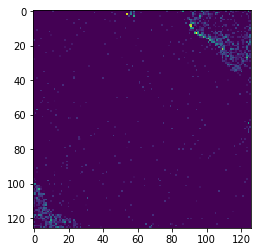

In [261]:
ds = H5Dataset(['../event_dump.h5'])
print(len(ds),'total events are loaded!')

ENTRY = 0
# Access an index
data,label,idx = ds[ENTRY]
# Data shape
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
# Visualize
plt.imshow(data[:,:,0])
plt.show()

In [262]:
def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

In [263]:
loader = DataLoader(ds,
                    batch_size=5,  # set the batch size = 50
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )
#time_record = loop(loader,10)
#print('Overall average iteration time:',time_record.mean(),'[s]')
#print('First event     iteration time:',time_record[0],    '[s]')
#print('After first event average time:',time_record[1:].mean(),'[s]')

In [264]:
for i,data in enumerate(loader):
    break

data[0].shape

(5, 126, 126, 2)

In [265]:
blob.net.cuda()
blob.net._feature[0].AA.is_cuda

True

In [266]:
import time

# Set the network to training mode
blob.net.train()
train_loader = loader

# Start training
for i,data in enumerate(train_loader):
    break

# Data and label
blob.data,blob.label = data[0:2]
# Call forward: make a prediction & measure the average error
res = forward(blob,True)
# Call backward: backpropagate error and update weights


In [267]:
res

{'prediction': array([[-0.15110272],
        [-0.14126244],
        [-0.1477893 ],
        [-0.15592791],
        [-0.11514048]], dtype=float32), 'mse': array([[1064616.9 ],
        [ 674647.06],
        [ 842219.44],
        [1294013.5 ],
        [ 237922.92]], dtype=float32), 'loss': 878.7434692382812, 'accuracy': 907.019287109375}

In [268]:
blob.optimizer.zero_grad()  # Reset gradients accumulation
#blob.loss.backward()
#blob.optimizer.step()

In [63]:
blob.loss.backward()

In [269]:
# ok, start over

class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(1).cuda() # construct CNN for 1 variable regression, use GPU
#blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.criterion = torch.nn.SmoothL1Loss()
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
#blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.mse       = torch.nn.MSELoss(reduction='none')
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [270]:
train_ds = H5Dataset(['../event_dump.h5'],start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(['../event_dump.h5'],start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [277]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-15 10:19:27


Epoch 1 Starting @ 2019-08-15 10:20:23


Epoch 2 Starting @ 2019-08-15 10:20:34


Epoch 3 Starting @ 2019-08-15 10:20:45


Epoch 4 Starting @ 2019-08-15 10:20:55


Epoch 5 Starting @ 2019-08-15 10:21:08


Epoch 6 Starting @ 2019-08-15 10:21:18


Epoch 7 Starting @ 2019-08-15 10:21:30


Epoch 8 Starting @ 2019-08-15 10:21:41


Epoch 9 Starting @ 2019-08-15 10:21:53


In [272]:
blob.test_log.name

'log_test.csv'

In [273]:
blob.train_log.name

'log_train.csv'

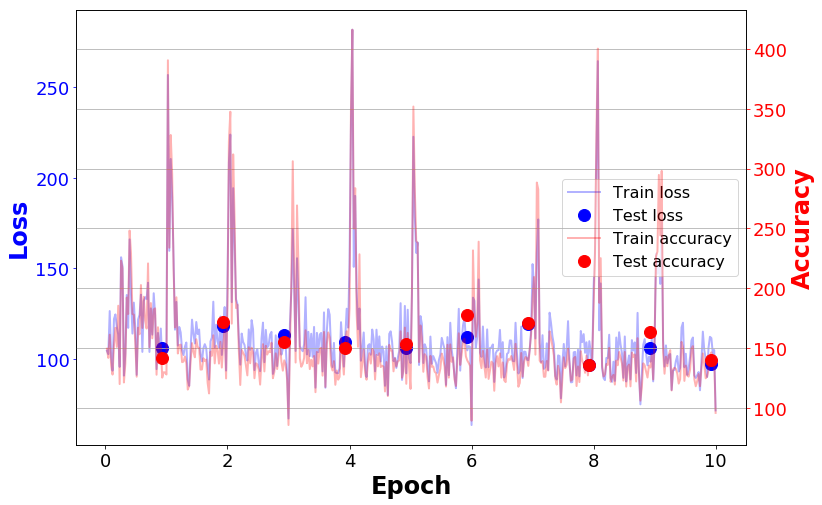

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
#ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

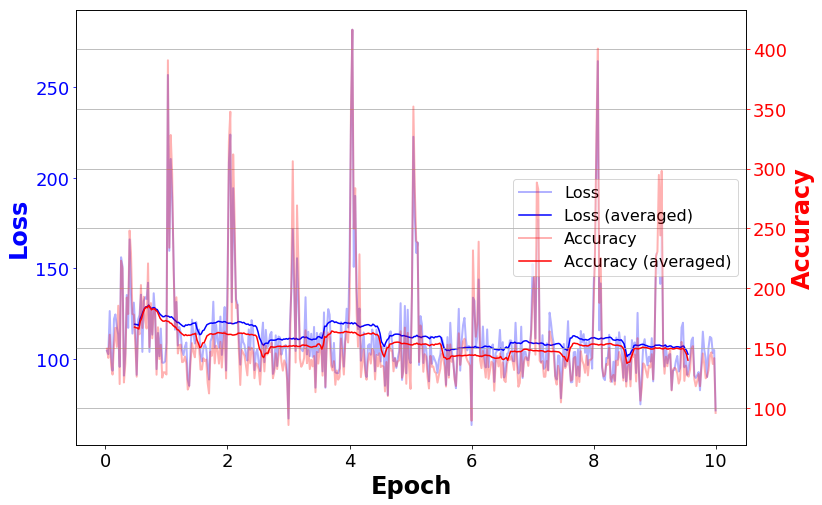

In [280]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
#ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [276]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

Accuracy mean 0.81 std 0.04000002


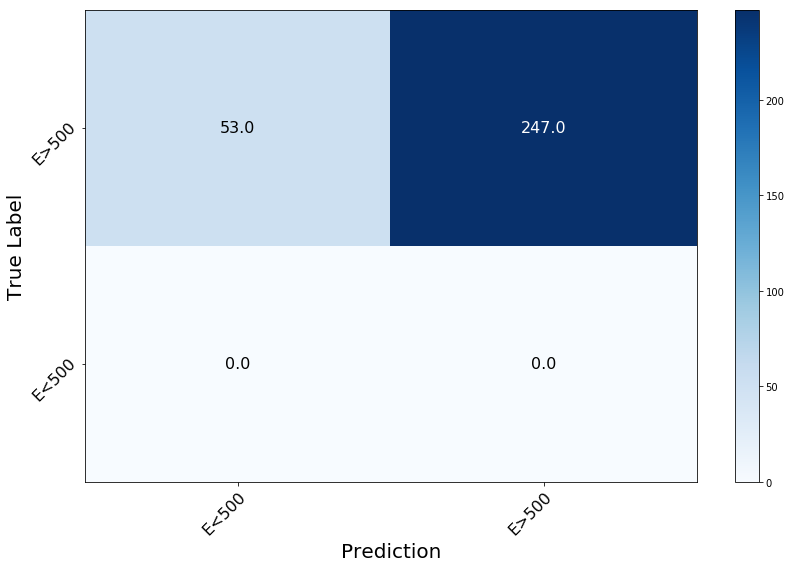

In [71]:
from utils.utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['E<500','E>500'])

I think "True Label" and "Prediction" is swapped

In [72]:
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [73]:
blob.net

CNN(
  (_feature): Sequential(
    (0): TopoConv2d(
      (conv2d): Conv2d(14, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ReLU()
    (2): TopoConv2d(
      (conv2d): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
  )
  (_classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [89]:
blob.net._feature[0].conv2d.weight

Parameter containing:
tensor([[[[-0.0042]],

         [[ 0.2737]],

         [[-0.2300]],

         [[ 0.0160]],

         [[-0.0391]],

         [[-0.0076]],

         [[-0.1495]],

         [[ 0.2577]],

         [[ 0.0479]],

         [[ 0.2626]],

         [[ 0.1084]],

         [[ 0.1871]],

         [[-0.0067]],

         [[-0.0211]]],


        [[[ 0.1101]],

         [[-0.0172]],

         [[-0.1166]],

         [[-0.2508]],

         [[-0.0539]],

         [[ 0.1154]],

         [[-0.2726]],

         [[-0.2499]],

         [[-0.2240]],

         [[ 0.0819]],

         [[-0.1338]],

         [[-0.1247]],

         [[ 0.1664]],

         [[-0.2586]]],


        [[[ 0.1124]],

         [[-0.0579]],

         [[-0.1125]],

         [[ 0.0035]],

         [[ 0.0504]],

         [[ 0.2604]],

         [[ 0.0407]],

         [[-0.2122]],

         [[ 0.0159]],

         [[-0.1168]],

         [[-0.2096]],

         [[ 0.1840]],

         [[ 0.2375]],

         [[-0.2481]]],


      

In [90]:
label

array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [ ]:
label,prediction,accuracy=[],[],[]

# set the network to test (non-train) mode
blob.net.eval()
# create the result holder
index,label,prediction = [],[],[]
for i,data in enumerate(data_loader):
    blob.data, blob.label = data[0:2]
    res = forward(blob,True)
    accuracy.append(res['accuracy'])
    prediction.append(res['prediction'])
    label.append(blob.label)
    #if i==2: break